# Example
---

In this notebook we will present an application of the code developed. For the example we use the information from Preferencial Bancolombia (a preffered stock for a commercial bank) with the following ticker: PFBCOLO

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from zipfile import ZipFile

In [ ]:
#Unzip data
## unzip the data
zip = ZipFile('taqcolombiasample.zip')
zip.extractall()

## Import data

In [50]:
data = pd.read_csv('intradayColombia.csv',parse_dates=['timestamp'], sep=',', 
                   na_values='NA', 
                   low_memory=False)

In [51]:
data.head()

,ticker,volume,timestamp,type,price
0,PFBCOLO CB Equity,0,2017-03-03 09:15:00,BID,0
1,PFBCOLO CB Equity,0,2017-03-03 09:15:00,ASK,0
2,PFBCOLO CB Equity,2000,2017-03-03 09:15:00,ASK,31800
3,PFBCOLO CB Equity,2000,2017-03-03 09:15:00,ASK,29500
4,PFBCOLO CB Equity,1913,2017-03-03 09:15:00,ASK,28500


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030561 entries, 0 to 1030560
Data columns (total 5 columns):
ticker       1030561 non-null object
volume       1030561 non-null int64
timestamp    1030561 non-null datetime64[ns]
type         1030561 non-null object
price        1030561 non-null int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 39.3+ MB


## Preprocessing
---
Now we begin to preprocess our data with the `StockPreprocessing(stockdata, stock_ticker)` method.

In [53]:
from PreprocessPipeline import *

### Choose a particular stock from the list (PFBCOLO, ECOPETL, BCOLO, PFAVAL, ISA)

In [54]:
ticker='PFBCOLO'

In [55]:
# The intial preprocessing is applied
prep_data = StockPreprocessing(data, ticker)

In [56]:
# Lets check out the output
prep_data.head()

,dia,nombre,tipo,precio,volumen,ASK,BID,Mid_price,Quoted_Spread
date_time,,,,,,,,,
2017-03-03 09:30:00,2017-03-03,PFBCOLO CB Equity,BID,27200,10000,NaN,NaN,NaN,NaN
2017-03-03 09:30:00,2017-03-03,PFBCOLO CB Equity,BID,27220,3452,NaN,NaN,NaN,NaN
2017-03-03 09:30:00,2017-03-03,PFBCOLO CB Equity,ASK,27480,148,27480.0,27220.0,27350.0,0.009506
2017-03-03 09:30:00,2017-03-03,PFBCOLO CB Equity,BID,27220,8452,27480.0,27220.0,27350.0,0.009506
2017-03-03 09:30:00,2017-03-03,PFBCOLO CB Equity,BID,27220,5000,27480.0,27220.0,27350.0,0.009506


Depths are calculated with the `StockDepth(stockdata, stock_ticker)` method

In [57]:
# The depths are calculated
depth_data = StockDepth(prep_data, ticker)
#depth_data.to_csv

In [67]:
depth_data.head()

,dia,nombre,tipo,precio,ASK,BID,Mid_price,Quoted_Spread,volumen,ASK_depth,BID_depth,Depth,log_depth
date_time,,,,,,,,,,,,,
2017-03-03 09:30:00,2017-03-03,PFBCOLO CB Equity,BID,27200,NaN,NaN,NaN,NaN,10000,0,10000,10000,9.210340
2017-03-03 09:30:00,2017-03-03,PFBCOLO CB Equity,BID,27220,NaN,NaN,NaN,NaN,3452,0,13452,13452,9.506883
2017-03-03 09:30:00,2017-03-03,PFBCOLO CB Equity,ASK,27480,27480.0,27220.0,27350.0,0.009506,148,148,13452,13600,9.517825
2017-03-03 09:30:00,2017-03-03,PFBCOLO CB Equity,BID,27220,27480.0,27220.0,27350.0,0.009506,8452,148,21904,22052,10.001159
2017-03-03 09:30:00,2017-03-03,PFBCOLO CB Equity,BID,27220,27480.0,27220.0,27350.0,0.009506,5000,148,26904,27052,10.205516


## Price impact
---

We assume that the trade activity of a stock has a linear price impact which depends on the net price change and the order of the transaction, which we call `order_flow`.

To calculate order flow, we need to identify the transactions initiating party with the `InitiatingParty(stockdata)` method.

In [58]:
# To calculate order flow, we need to identify the transactions initiating party
init_party = InitiatingParty(depth_data)

In [59]:
# Checking the output
init_party[['nombre', 'tipo', 'precio', 'iniciado']].head()

,nombre,tipo,precio,iniciado
date_time,,,,
2017-03-03 09:31:00,PFBCOLO CB Equity,TRADE,27220,-1.0
2017-03-03 09:50:00,PFBCOLO CB Equity,TRADE,27400,-1.0
2017-03-03 09:53:00,PFBCOLO CB Equity,TRADE,27420,-1.0
2017-03-03 10:01:00,PFBCOLO CB Equity,TRADE,27480,1.0
2017-03-03 10:02:00,PFBCOLO CB Equity,TRADE,27480,-1.0


Now we can obtain net price change and order flow with `ImpactParameters(stockdata, stock_ticker)`

In [60]:
# Impact parameters for the linear regression
impact_params = ImpactParameters(init_party, ticker)

In [61]:
impact_params[['nombre', 'tipo', 'precio', 'iniciado', 'delta_p', 'order_flow']].head()

,nombre,tipo,precio,iniciado,delta_p,order_flow
date_time,,,,,,
2017-03-03 09:31:00,PFBCOLO CB Equity,TRADE,27220,-1.0,NaN,-100.0
2017-03-03 09:50:00,PFBCOLO CB Equity,TRADE,27400,-1.0,180.0,-115.0
2017-03-03 09:53:00,PFBCOLO CB Equity,TRADE,27420,-1.0,20.0,-100.0
2017-03-03 10:01:00,PFBCOLO CB Equity,TRADE,27480,1.0,60.0,77.0
2017-03-03 10:02:00,PFBCOLO CB Equity,TRADE,27480,-1.0,0.0,-71.0


Finally, we perform the linear regression with `KyleImpactRegression(stockdata, stock_ticker)`

In [62]:
# Linear regression
kyle_reg = KyleImpactRegression(impact_params, ticker)

In [63]:
kyle_reg.head()

,coef_regresion,p_value,trades
dia,,,
2017-03-03,0.006282,0.395476,67
2017-06-03,0.001316,0.836483,87
2017-07-03,0.000492,0.263183,135
2017-08-03,0.000174,0.566009,129
2017-09-03,0.000013,0.810125,132


In [64]:
kyle_reg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 119 entries, 2017-03-03 to 2017-08-31
Data columns (total 3 columns):
coef_regresion    119 non-null float64
p_value           119 non-null float64
trades            119 non-null int64
dtypes: float64(2), int64(1)
memory usage: 3.7 KB


# Market quality parameters: visualization
---

Once we have performed all preliminary calculations, we can visualize the intra-day market quality parameters. In order to do this, we will use the `graph(stockdata, stock_ticker, param)` method we developed.

In [65]:
from Visualization import *

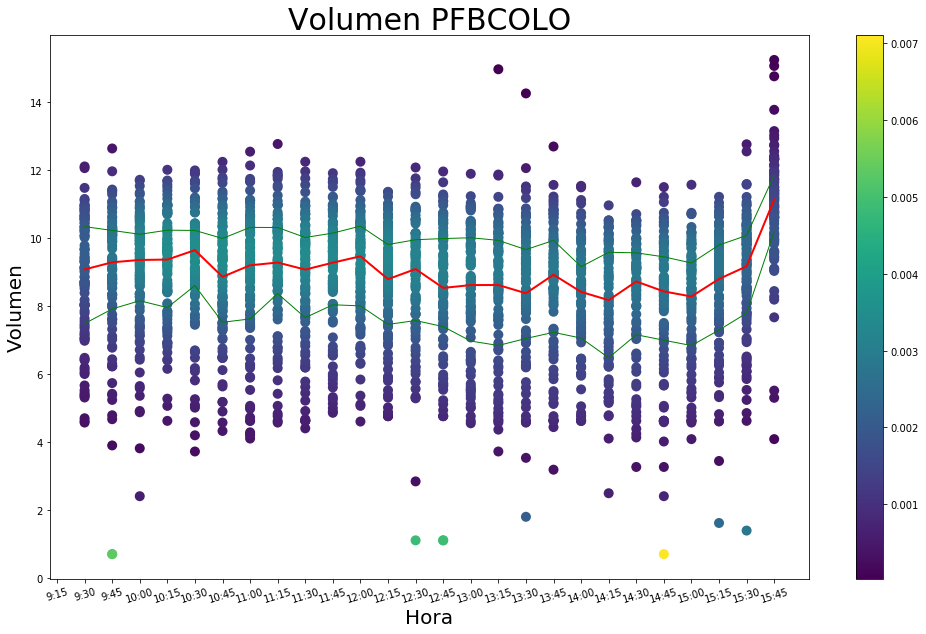

In [66]:
param_list = ["log_depth", "Volatilidad", "Spread", "Volumen"]

K = 3
graph(depth_data, ticker, param_list[K])